In [104]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import os
import seaborn as sns
sns.set(style="whitegrid")

# Declarative and Procedural Control

Several proejcts in the lab (e.g., Cher's, Teddy's) depend on identifying whether participants rely on declarative vs. proceodural "strategies" during decision making. To do so, we typically compute the log-likelihood that a model generates each participant's data. This is extremely lengthy and expensive in ACT-R. Furthermore, it requires aggregating the data in some way, while most models apply log-likelihood in to trial-by-trial choices.

A way to work around these problems is to use simpler Python code than ACT-R. When the declarative and procedural systems do not interact, it is simpler to code them directly in Python (they are, after all, just a series of equations). Thus, declarative and procedural strategies becom Python functions, and can be fit to trial-by-trial data.

Here is some example code that uses Cher's data as an example. Cher's data uses the Incentive Processing Task from the HCP, in which participabnts press buttons corresponding to "more" and "less" and guess whether a hidden number is greater or smaller than 5. They get feedback after every choice, depending on whether the number of greater, smaller, or equal to 5. Unbeknownst to them, the task is rigged: The schedule of rewards and losses is fixed.

Let's start by recording the feedback and the associated rewards in dollars:

In [105]:
# Mapping of feedback to reward
rewards = {"Punishment" : -0.5, 
           "Reward" : 1.0,
           "Neutral" : 0.0} 

Example data from one participant

In [151]:
#data = pd.read_csv("subject_data/109123_fnca/subject.csv")
data = pd.read_csv("subject_data/103818_fnca/subject.csv")
#data = pd.read_csv("subject_data/150523_fnca/subject.csv")
data

,Unnamed: 0,HCPID,Trial,RunNumber,TrialType,RunTrialNumber,Block,CurrentResponse,QuestionMark.ACC,RT,...,ConsecSameResp,ConsecLargerGuesses,ConsecSmallerGuesses,ConsecRTLess200,FutureResponse,PastResponse,ResponseSwitch,PreviousFeedback,BlockType,BlockTypeCoded
0,833,103818_fnca,1,1,Reward,2,5,3.0,0,527,...,1,1,0,0,3.0,NaN,0.0,NaN,MostlyReward,MostlyReward
1,834,103818_fnca,2,1,Reward,3,5,3.0,0,709,...,2,2,0,0,2.0,3.0,1.0,Reward,MostlyReward,MostlyReward
2,835,103818_fnca,3,1,Punishment,4,5,2.0,0,922,...,1,0,1,0,2.0,3.0,0.0,Reward,MostlyReward,MostlyReward
3,836,103818_fnca,4,1,Reward,5,5,2.0,0,773,...,2,0,2,0,3.0,2.0,1.0,Punishment,MostlyReward,MostlyReward
4,837,103818_fnca,5,1,Reward,6,5,3.0,0,1041,...,1,1,0,0,3.0,2.0,0.0,Reward,MostlyReward,MostlyReward
5,838,103818_fnca,6,1,Reward,7,5,3.0,0,568,...,2,2,0,0,3.0,3.0,0.0,Reward,MostlyReward,MostlyReward
6,839,103818_fnca,7,1,Neutral,8,5,3.0,0,655,...,3,3,0,0,3.0,3.0,0.0,Reward,MostlyReward,MostlyReward
7,841,103818_fnca,10,1,Reward,10,5,2.0,0,866,...,1,0,1,0,3.0,NaN,1.0,NaN,MostlyPunishment,MostlyPunishment
8,842,103818_fnca,11,1,Punishment,11,5,3.0,0,851,...,1,1,0,0,2.0,2.0,1.0,Reward,MostlyPunishment,MostlyPunishment
9,843,103818_fnca,12,1,Punishment,12,5,2.0,0,906,...,1,0,1,0,3.0,3.0,1.0,Punishment,MostlyPunishment,MostlyPunishment


## Assigning Probabilities to Choices

Both declarative and procedural models assume that the choices have associated values (e.q., Q-values, activations), and that these values affect the probability that a particular choice is selected. A standard way to transform these values into probabilities is the Boltzmann equation:

$P(c) = \frac{e^{V(c)/\tau}}{\sum_ie^{V(i)/\tau}}$

Where $V(c)$ is the value of choice $c$ and $\tau$ is the Boltzman _temperature_ that determines noise in the choices.

Here is the equivalent Python code:

In [107]:
def boltzmann(options, values, temperature):
    """Returns a Boltzmann distribution of the probabilities of each option"""
    temperature = max(temperature, 0.01) 
    vals = np.array(values)/temperature
    #bvals = np.exp(vals)/np.sum(np.exp(vals))
    bvals = np.exp(vals - np.max(vals)) / np.exp(vals - np.max(vals)).sum()
    return dict(zip(options, bvals))

For example, here are the probabilities of choosing between keys "2"and "3" (as in Cher's experiment) when they have an associated value of 1 and 5 and the noise is 5.

In [150]:
boltzmann([2,3], [1, 0.7], 1)

{2: 0.574442516811659, 3: 0.425557483188341}

# Procedural Log Likelihood

Now, let's calculate the log-likelihood for a procedural model that uses _Q_-learning. This function iterates over every choice made by the participant, computers the probability of that specific choice, and adds the log of this probability tothe cumulative log-likelihood. After every choice, it also updates the _Q_-values based on feedback 

In [109]:
def LLproc(data, alpha, temp):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    choices = list(set(data.CurrentResponse))
    Q = dict(zip(choices, [0 for x in choices]))
    LL = 0.0
    for response, feedback in zip(data.CurrentResponse, data.TrialType):
        # Calculate log likelihood of response
        options = Q.keys()
        values = [Q[opt] for opt in options]
        prob = boltzmann(options, values, temp)[response]
        
        # Sum up the LLs
        LL += np.log(max(prob, 10e-10))
        
        # Updates the Q values using Q-learning
        Q_old = Q[response]
        reward = rewards[feedback]
        Q[response] = Q_old + alpha *(reward - Q_old)
    return LL


As an example, we can calculate and visualize the log-lilihoods that the function would generate our subject's data for several values of $\alpha$ and $\tau$

In [110]:
alphaspace = np.linspace(0.2, 1, 11)
tempspace = np.linspace(0.2, 1, 11)
matrix = np.zeros((len(alphaspace), len(tempspace)))
for i, a in enumerate(alphaspace):
    for j, t in enumerate(tempspace):
        matrix[i,j] = LLproc(data, a, t)

Visualize the parameter space

/tmp/ipykernel_646097/1317907275.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [str(round(x,2)) for x in alphaspace])
/tmp/ipykernel_646097/1317907275.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + [str(round(x, 2)) for x in tempspace])


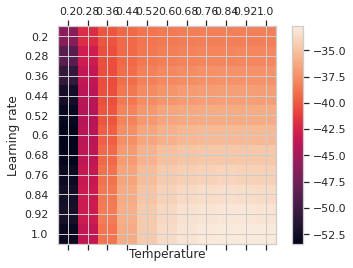

In [111]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix, interpolation='nearest')
fig.colorbar(cax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + [str(round(x,2)) for x in alphaspace])
ax.set_yticklabels([''] + [str(round(x, 2)) for x in tempspace])
ax.set_ylabel("Learning rate")
ax.set_xlabel("Temperature")
plt.show()

## Optimize Procedural Model Using Machine Learning

Instead of using grid search, we can use standard optimization procedures for identifying the best set of parameters for each participant. First, we need to create a vectorized version of the `LLproc` procedure:

In [112]:
def vLLproc(array):
    """Vector function of data"""
    global data
    alpha = array[0]
    temp = array[1]
    return -1*LLproc(data, alpha, temp)

And, then, we just apply the Nelder-Mead algorithm from the `scipy.optimize` package:

In [113]:
opt.minimize(vLLproc, x0 = [0.5, 0.5], method = "Nelder-Mead")

 final_simplex: (array([[1.08675937, 0.94431972],
       [1.08670911, 0.9442999 ],
       [1.08675678, 0.94441357]]), array([32.59532393, 32.59532394, 32.59532396]))
           fun: 32.59532393358014
       message: 'Optimization terminated successfully.'
          nfev: 71
           nit: 38
        status: 0
       success: True
             x: array([1.08675937, 0.94431972])

# Declarative Model

We can do the the same for ta declarative model.  As before, we can create a declarative LL function based on ACT-R. First, we need to create an _activation_ function, which would predict the activation of a memory given its history of usage, the time at which activation is computed, and the decay rate. According to ACT-R, a memory's activation $A(t)$ is the logarithm of its decaying traces:

$ A(t) = \log \sum_i (t - t_i)^d$

In [114]:
def activation(traces, time, decay):
    """Computes the activation of a memory given its history of retrievals"""
    ftraces = [x for x in traces if x < time]
    decay = max(0, decay)  # Allows no positive decay rates in equation 
    decay - min(decay, 5)
    times = time - np.array(ftraces)
    odds = times ** -decay
    return np.log(np.sum(odds))

activation([5, 10, 15], 40, 0.5)

-0.5949230018850301

This is a normal activation function that gives us decay over time:

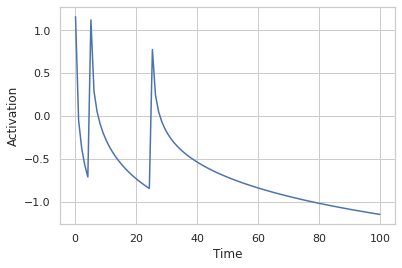

In [115]:
time = np.linspace(0.1, 100, 100)
traces = [0.001, 5, 25]
y = []
for t in time:
    act = activation(traces, t, 0.5)
    y += [act]
    
plt.plot(time, y)
plt.xlabel("Time")
plt.ylabel("Activation")
plt.show()

Now let's create a log-likelihood function for the declarative model: For very choice made by the participant, the function computes the probability of retrieving a success associated with that choice, then updates the cumulative log-likelihood and, if the decision was successful, adds another trace to memory

In [116]:
def LLdecl(data, decay, temp):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    choices = list(set(data.CurrentResponse))
    DM = dict(zip(choices, [[0.001] for x in choices]))
    LL = 0.0
    time = 15
    trial = 1
    step = 3.5
    for response, feedback in zip(data.CurrentResponse, data.TrialType):
        # Calculate log likelihood of response
        options = DM.keys()
        values = [activation(DM[opt], time, decay) for opt in options]
        prob = boltzmann(options, values, temp)[response]
        
        # Sum up the LLs
        LL += np.log(max(prob, 10e-10))
        # If we have a positive feedback, add a trace
        if rewards[feedback] > 0:
            DM[response] += [time]
        
        if trial % 7 == 0:
            time += 15  # Fixation block
        else:
            time += step # onset of next trial
            
        # Skip a week between sessions
        if trial % 28 == 0:
            time += (7 * 24 * 60 * 60)
        
        trial += 1
        
    return LL

Simple test with subject data

In [117]:
LLdecl(data, 0.5, 1)

-40.650676020239835

Let's visualize the log-likelihood space

/tmp/ipykernel_646097/2575681153.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [str(round(x,2)) for x in alphaspace])
/tmp/ipykernel_646097/2575681153.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + [str(round(x, 2)) for x in tempspace])


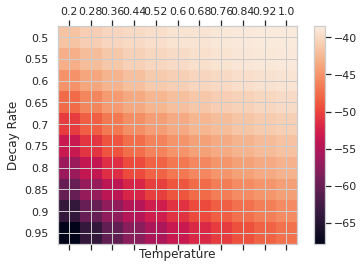

In [118]:
decayspace = np.linspace(0.1, 1, 10)
tempspace = np.linspace(0.5, 1, 11)
matrix = np.zeros((len(decayspace), len(tempspace)))
for i, d in enumerate(decayspace):
    for j, t in enumerate(tempspace):
        matrix[i,j] = LLdecl(data, d, t)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix, interpolation='nearest')
fig.colorbar(cax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + [str(round(x,2)) for x in alphaspace])
ax.set_yticklabels([''] + [str(round(x, 2)) for x in tempspace])
ax.set_ylabel("Decay Rate")
ax.set_xlabel("Temperature")
plt.show()

## Optimization of Declarative Memory Model

As usual, first we start by creating a vector function 

In [119]:
def vLLdecl(array):
    """Vector function of data"""
    global data
    decay = array[0]
    temp = array[1]
    return -1*LLdecl(data, decay, temp)

And then, we optimize

In [120]:
opt.minimize(vLLdecl, x0 = [0.2, 1], method = "Nelder-Mead")

 final_simplex: (array([[0.45050002, 2.8370537 ],
       [0.45049457, 2.83696138],
       [0.45052303, 2.83709358]]), array([37.92308234, 37.92308234, 37.92308234]))
           fun: 37.92308233898991
       message: 'Optimization terminated successfully.'
          nfev: 124
           nit: 64
        status: 0
       success: True
             x: array([0.45050002, 2.8370537 ])

# Assign all Subjects

We can now loop over all of Cher's participants (_N_=199) and compute the best parameters and high log-liklihoods of each model for each participant.  

In [121]:
DO_ALL = False
dataframe = []

if DO_ALL:
    for folder in os.listdir("subject_data"):
        if folder.endswith("_fnca"):
            data = pd.read_csv("subject_data/" + folder + "/subject.csv")
            alpha, ptemp = opt.minimize(vLLproc, x0 = [0.1, 1], method = "Powell", bounds=[[0.01, 2], [0, 100]]).x
            #alpha, ptemp = opt.minimize(vLLproc, x0 = [0.1, 1], method='trust-constr',  jac="2-point", #hess=0, #hess=opt.SR1(), 
            #                            bounds=opt.Bounds((0.01, 2), (0, 100))).x
            llproc = LLproc(data, alpha, ptemp)
            
            decay, dtemp = opt.minimize(vLLdecl, x0 = [0.5, 1], method = "Powell", bounds=[[0.01, 2], [0, 100]]).x
            #decay, dtemp = opt.minimize(vLLdecl, x0 = [0.5, 1], method='trust-constr',  jac="2-point", #hess=0, #hess=opt.SR1(), 
            #                            bounds=opt.Bounds((0.01, 2), (0, 100))).x
            lldecl = LLdecl(data, decay, dtemp)
            
            best = "Declarative"
            if llproc > lldecl:
                best = "Procedural"
            
            diff = llproc - lldecl
            
            row = [folder, alpha, ptemp, llproc, decay, dtemp, lldecl, best, diff]
            
            dataframe += [row]

    result = pd.DataFrame(dataframe, columns=["HCPID", "alpha", "proc.temp", "proc.LL", "decay", "decl.temp", "decl.LL", "best.model", "diff.LL"])    

Here are the results

In [122]:
if DO_ALL:
    result.to_csv("LL_proc_decl.csv")
else:
    result = pd.read_csv("LL_proc_decl.csv")
result

,Unnamed: 0,HCPID,alpha,proc.temp,proc.LL,decay,decl.temp,decl.LL,best.model,diff.LL
0,0,173132_fnca,0.451223,0.776283,-34.927074,0.010004,1.525656,-36.699627,Procedural,1.772553
1,1,161731_fnca,0.010053,100.000000,-38.816821,0.010066,100.000000,-38.833632,Procedural,0.016811
2,2,150523_fnca,0.574209,0.542036,-15.386656,1.823239,2.830250,-16.805735,Procedural,1.419079
3,3,173940_fnca,1.592287,3.960880,-37.552324,0.389084,8.739970,-38.769391,Procedural,1.217067
4,4,169343_fnca,1.689978,4.843712,-37.567052,0.010002,3.903523,-37.692313,Procedural,0.125261
...,...,...,...,...,...,...,...,...,...,...
194,194,147737_fnca,0.105373,1.027209,-37.960643,0.010059,100.000000,-38.126588,Procedural,0.165945
195,195,127933_fnca,1.383080,4.943653,-38.213468,0.010018,100.000000,-38.873551,Procedural,0.660083
196,196,122620_fnca,0.397623,1.554127,-37.947207,0.010001,2.533350,-38.596649,Procedural,0.649442
197,197,146331_fnca,0.010043,100.000000,-38.817134,0.010064,100.000000,-38.825095,Procedural,0.007961


Visualize the distribution LL differences and the number of Declarative / Procedural participants identified by the models

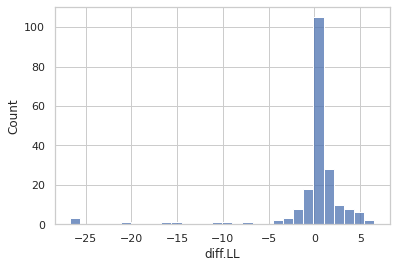

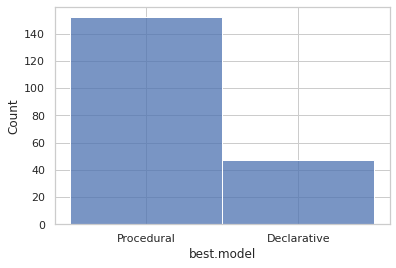

In [123]:
sns.histplot(result, x="diff.LL", bins=30)
plt.show()
sns.histplot(result, x="best.model")
plt.show()

Let's visualize the parameters of the procedural model


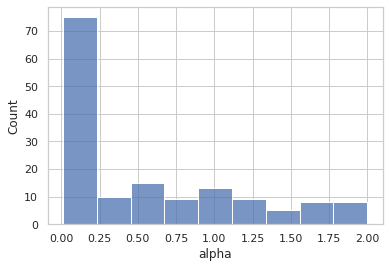

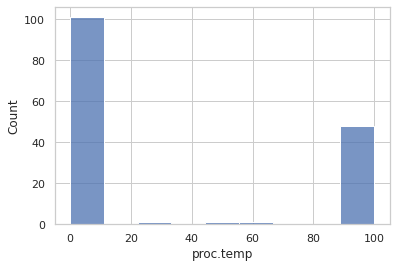

In [124]:
procedural = result[result['best.model'] == "Procedural"]
sns.histplot(procedural, x="alpha")
plt.show()
sns.histplot(procedural, x="proc.temp")
plt.show()

And now, the declarative models

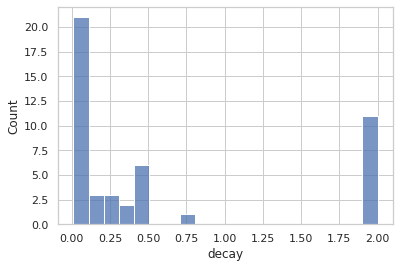

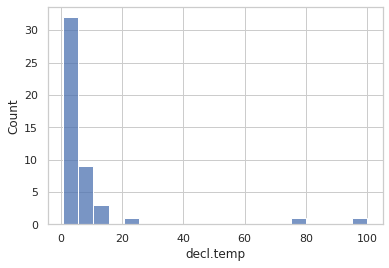

In [125]:
declarative = result[result['best.model'] == "Declarative"]
sns.histplot(declarative, x="decay", bins=20)
plt.show()
sns.histplot(declarative, x="decl.temp", bins=20)
plt.show()

# Alternative Version of Declarative Model

In this version, there are two routes to make a decision: To remember something that worked and to remember something that did _not_. The total probability of a choice $c$ is given by the probability of retrieving two possible memories, one that associates $c$ with reward $+1$ and one that associates the other choice $-c$ with punishment $-0.5$: 

$P(c) = P(c, 1) + P(\neg c, -0.5)$

In [126]:
def LLdecl2(data, decay, temp):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    choices = list(set(data.CurrentResponse))
    outcomes = [rewards[x] for x in rewards.keys() if x != "Neutral"]
    memories = ["%s-%s" % (choice, outcome) for choice in choices for outcome in outcomes]
    DM = dict(zip(memories, [[0.001] for x in memories]))
    
    LL = 0.0
    time = 15
    trial = 1
    step = 3.5
    
    for response, feedback in zip(data.CurrentResponse, data.TrialType):
        # Calculate log likelihood of response
        options = DM.keys()
        values = [activation(DM[opt], time, decay) for opt in options]
        probs = boltzmann(options, values, temp)
        
        # The probability of picking option X is the probability of retrieving a success for X 
        # plus the probability of retrieving a punishment for Y.
        prob1 = probs["%s-%s" % (response, 1.0)]
        other = [x for x in choices if x != response]
        prob2 = probs["%s-%s" % (other[0], -0.5)]
        
        
        # Sum up the LLs
        LL += np.log(max(prob1 + prob2, 10e-10))
        
        # If we have a non-neutral feedback, add a trace
        if rewards[feedback] != 0:
            DM["%s-%s" % (response, rewards[feedback])] += [time]
        
        if trial % 7 == 0:
            time += 15  # Fixation block
        else:
            time += step # onset of next trial
            
        
        if trial % 28 == 0:
            time += (7 * 24 * 60 * 60) # Add a week between sessions.
        
        trial += 1
        
    return LL

def vLLdecl2(array):
    """Vector function of data"""
    global data
    decay = array[0]
    temp = array[1]
    return -1*LLdecl2(data, decay, temp)

Let's do the analysis again, using this new method

In [127]:
DO_ALL_AGAIN = False
dataframe = []

if DO_ALL_AGAIN:
    for folder in os.listdir("subject_data"):
        if folder.endswith("_fnca"):
            data = pd.read_csv("subject_data/" + folder + "/subject.csv")
            alpha, ptemp = opt.minimize(vLLproc, x0 = [0.1, 1], method = "Powell", bounds=[[0.01, 2], [0, 20]]).x
            llproc = LLproc(data, alpha, ptemp)
            
            decay, dtemp = opt.minimize(vLLdecl2, x0 = [0.5, 1], method = "Powell", bounds=[[0.01, 2], [0, 20]]).x
            lldecl = LLdecl2(data, decay, dtemp)
            
            best = "Declarative"
            if llproc > lldecl:
                best = "Procedural"
            
            diff = llproc - lldecl
            
            row = [folder, alpha, ptemp, llproc, decay, dtemp, lldecl, best, diff]
            
            dataframe += [row]

    result2 = pd.DataFrame(dataframe, columns=["HCPID", "alpha", "proc.temp", "proc.LL", "decay", "decl.temp", "decl.LL", "best.model", "diff.LL"])    

In [128]:
dataframe

[]

And let's save and visualize the results

In [129]:
if DO_ALL_AGAIN:
    result2.to_csv("LL_proc_decl2_new.csv")
else:
    result2 = pd.read_csv("LL_proc_decl2.csv")
result2

,Unnamed: 0,HCPID,alpha,proc.temp,proc.LL,decay,decl.temp,decl.LL,best.model,diff.LL
0,0,173132_fnca,0.451223,0.776283,-34.927074,1.999925,14.660278,-36.932228,Procedural,2.005154
1,1,161731_fnca,0.010053,100.000000,-38.816821,0.010080,100.000000,-38.822160,Procedural,0.005339
2,2,150523_fnca,0.574209,0.542036,-15.386656,0.010000,0.250336,-16.122680,Procedural,0.736024
3,3,173940_fnca,1.592287,3.960880,-37.552324,0.374057,1.177352,-37.626789,Procedural,0.074464
4,4,169343_fnca,1.689978,4.843712,-37.567052,0.010048,0.505439,-35.774523,Declarative,-1.792529
...,...,...,...,...,...,...,...,...,...,...
194,194,147737_fnca,0.105373,1.027209,-37.960643,0.267435,2.727740,-38.000503,Procedural,0.039860
195,195,127933_fnca,1.383080,4.943653,-38.213468,1.030428,100.000000,-38.846794,Procedural,0.633327
196,196,122620_fnca,0.397623,1.554127,-37.947207,0.010071,100.000000,-38.819881,Procedural,0.872674
197,197,146331_fnca,0.010043,100.000000,-38.817134,1.999993,12.741956,-38.410336,Declarative,-0.406799


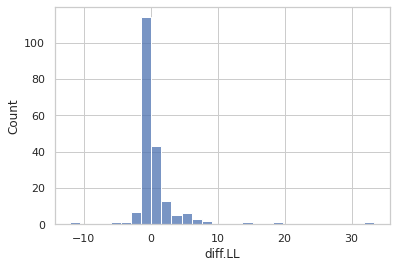

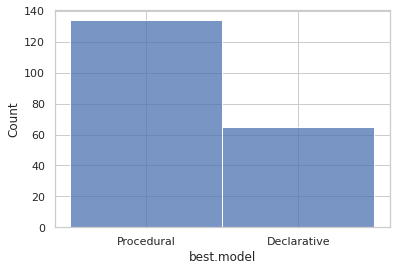

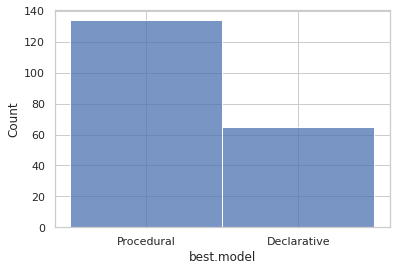

In [130]:
result2.value_counts("best.model")
sns.histplot(result2, x="diff.LL", bins=30)
plt.show()
sns.histplot(result2, x="best.model")
plt.show()

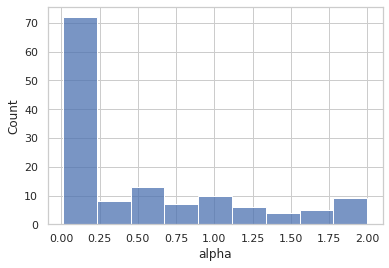

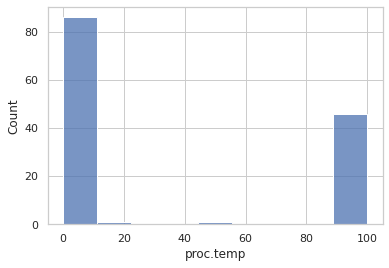

In [131]:
procedural = result2[result2['best.model'] == "Procedural"]
sns.histplot(procedural, x="alpha")
plt.show()
sns.histplot(procedural, x="proc.temp")
plt.show()

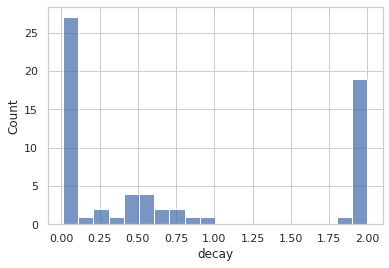

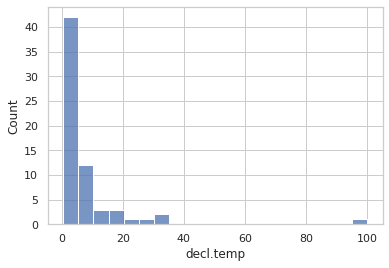

In [132]:
declarative = result2[result2['best.model'] == "Declarative"]
sns.histplot(declarative, x="decay", bins=20)
plt.show()
sns.histplot(declarative, x="decl.temp", bins=20)
plt.show()

# How Reliable Are the Assignments? Model Recovery

Here we can attempt model recovery.

In [133]:
def policy(bprobs):
    options = list(bprobs.keys())
    probs = [bprobs[opt] for opt in options]
    return np.random.choice(options, p=probs)
    

def simulate_data_proc(data, alpha, temp):
    """Produces a series of choices based on the experiences of a single participant"""
    choices = list(set(data.CurrentResponse))
    Q = dict(zip(choices, [0 for x in choices]))
    dataframe = []
    for feedback in data.TrialType:
        options = Q.keys()
        values = [Q[opt] for opt in options]
        boltz_probs = boltzmann(options, values, temp)
        response = policy(boltz_probs)
        
        dataframe += [[response, feedback]]
        
        Q_old = Q[response]
        reward = rewards[feedback]
        Q[response] = Q_old + alpha * (reward - Q_old)
    return pd.DataFrame(dataframe, columns=["CurrentResponse", "TrialType"])


def simulate_data_decl(data, alpha, temp):
    """Produces a series of choices based on the experiences of a single participant"""
    choices = list(set(data.CurrentResponse))
    Q = dict(zip(choices, [0 for x in choices]))
    dataframe = []
    for feedback in data.TrialType:
        options = Q.keys()
        values = [Q[opt] for opt in options]
        boltz_probs = boltzmann(options, values, temp)
        response = policy(boltz_probs)
        
        dataframe += [[response, feedback]]
        
        Q_old = Q[response]
        reward = rewards[feedback]
        Q[response] = Q_old + alpha * (reward - Q_old)
    return pd.DataFrame(dataframe, columns=["CurrentResponse", "TrialType"])
        

def simulate_data_decl2(data, decay, temp):
    choices = list(set(data.CurrentResponse))
    outcomes = [rewards[x] for x in rewards.keys() if x != "Neutral"]
    memories = ["%s-%s" % (choice, outcome) for choice in choices for outcome in outcomes]
    DM = dict(zip(memories, [[0.1] for x in memories]))    
    
    time = 15
    trial = 1
    step = 3.5
    
    dataframe = []
    
    for feedback in data.TrialType:
        # Calculate log likelihood of response
        options = DM.keys()
        values = [activation(DM[opt], time, decay) for opt in options]
        boltz_probs = boltzmann(options, values, temp)
        
        memory = policy(boltz_probs)
        response = float(memory[0:3]) # Turn first three chars into a float number
        
        if float(memory[4:]) < 0:
            other = [x for x in choices if x != response]
            response = other[0]
        
        dataframe += [[response, feedback]]
        
        if rewards[feedback] != 0:
            DM["%s-%s" % (response, rewards[feedback])] += [time]
        
        if trial % 7 == 0:
            time += 15  # Fixation block
        else:
            time += step # onset of next trial
            
        
        if trial % 28 == 0:
            time += (7 * 24 * 60 * 60) # Add a week between sessions.
        
        trial += 1
        
    return pd.DataFrame(dataframe, columns=["CurrentResponse", "TrialType"])

    
    
def model_recovery(simdata):
    """Comparative fit of model"""
    alpha, ptemp = opt.minimize(vLLproc, x0 = [0.1, 1], method = "Powell", bounds=[[0.01, 2], [0, 20]]).x
    llproc = LLproc(data, alpha, ptemp)
            
    decay, dtemp = opt.minimize(vLLdecl2, x0 = [0.5, 1], method = "Powell", bounds=[[0.01, 2], [0, 20]]).x
    lldecl = LLdecl2(data, decay, dtemp)
            
    best = "Declarative"
    if llproc > lldecl:
        best = "Procedural"
            
    diff = llproc - lldecl
            
    return [folder, alpha, ptemp, llproc, decay, dtemp, lldecl, best, diff]

In [134]:
k = simulate_data_decl2(data, 0.5, 1)
data = k
opt.minimize(vLLdecl2, x0 = [0.5, 0.5], bounds=[[0,2],[0, 10]], method = "Powell")

   direc: array([[0.        , 1.        ],
       [0.39934046, 2.20269487]])
     fun: 38.60949735977784
 message: 'Optimization terminated successfully.'
    nfev: 171
     nit: 5
  status: 0
 success: True
       x: array([0.97080996, 9.01323209])

In [135]:
DO_RECOVERY = True
recovery_df = []

if DO_RECOVERY:
    j = 1
    global data
    for folder in os.listdir("subject_data"):
        if folder.endswith("_fnca"):
            subj_data = pd.read_csv("subject_data/" + folder + "/subject.csv")
            print("%s, %d/199" % (folder, j)) 
            for model in ["Procedural", "Declarative"]:
                alpha = np.nan
                ptemp = np.nan
                decay = np.nan
                dtemp = np.nan
                results = []
                for run in range(10):
                    if model == "Procedural":
                        alpha = np.random.uniform(0.001, 2)
                        ptemp = np.random.uniform(0, 20)
                        
                        simdata = simulate_data_proc(subj_data, alpha, ptemp)
                        data = simdata
                        results = model_recovery(simdata)
                        
                    else:
                        decay = np.random.uniform(0.001, 2)
                        dtemp = np.random.uniform(0, 20)
                        
                        simdata = simulate_data_decl2(subj_data, decay, dtemp)
                        data = simdata
                        results = model_recovery(simdata)
                            
                    row = [model, alpha, ptemp, decay, dtemp] + results
                    recovery_df += [row]
            j += 1

#recovery_df = pd.DataFrame(recovery_df, columns=dataframe, columns=["orig.model", "orig.alpha", "orig.proc.temp", "orig.decay", "orig.decl.temp",
 #                                                                   "HCPID", "alpha", "proc.temp", "proc.LL", "decay", "decl.temp", "decl.LL", "best.model", "diff.LL"])    

            

173132_fnca, 1/199
161731_fnca, 2/199
150523_fnca, 3/199
173940_fnca, 4/199
169343_fnca, 5/199
167743_fnca, 6/199
151526_fnca, 7/199
177645_fnca, 8/199
178748_fnca, 9/199
172130_fnca, 10/199
172029_fnca, 11/199
159340_fnca, 12/199
158035_fnca, 13/199
111312_fnca, 14/199
125525_fnca, 15/199
150524_fnca, 16/199
140824_fnca, 17/199
126628_fnca, 18/199
116524_fnca, 19/199
123925_fnca, 20/199
173334_fnca, 21/199
120515_fnca, 22/199
103111_fnca, 23/199
992774_fnca, 24/199
165840_fnca, 25/199
115320_fnca, 26/199
159239_fnca, 27/199
108323_fnca, 28/199
140117_fnca, 29/199
102311_fnca, 30/199
145531_fnca, 31/199
113619_fnca, 32/199
139637_fnca, 33/199
127630_fnca, 34/199
163331_fnca, 35/199
138231_fnca, 36/199
106016_fnca, 37/199
172332_fnca, 38/199
144226_fnca, 39/199
104820_fnca, 40/199
153429_fnca, 41/199
133019_fnca, 42/199
157437_fnca, 43/199
135528_fnca, 44/199
165234_fnca, 45/199
131217_fnca, 46/199
158136_fnca, 47/199
167036_fnca, 48/199
166438_fnca, 49/199
128329_fnca, 50/199
173435_fn

In [136]:
recovery_df = pd.DataFrame(recovery_df, columns=["orig.model", "orig.alpha", "orig.proc.temp", "orig.decay", "orig.decl.temp",
                                                                    "HCPID", "alpha", "proc.temp", "proc.LL", "decay", "decl.temp", "decl.LL", "best.model", "diff.LL"])    


In [137]:
recovery_df.to_csv("model_recovery.csv")
recovery_df

,orig.model,orig.alpha,orig.proc.temp,orig.decay,orig.decl.temp,HCPID,alpha,proc.temp,proc.LL,decay,decl.temp,decl.LL,best.model,diff.LL
0,Procedural,0.696981,17.942866,NaN,NaN,173132_fnca,0.065717,0.440501,-36.058022,0.729670,1.506516,-35.339022,Declarative,-0.719000
1,Procedural,1.493608,6.673528,NaN,NaN,173132_fnca,0.010052,20.000000,-37.435520,0.010077,20.000000,-37.464946,Procedural,0.029425
2,Procedural,1.969339,2.048459,NaN,NaN,173132_fnca,1.886234,1.297093,-18.816339,2.000000,19.992351,-36.549822,Procedural,17.733483
3,Procedural,1.810123,18.435599,NaN,NaN,173132_fnca,0.023324,1.130094,-37.274957,0.360201,4.293245,-37.189625,Declarative,-0.085332
4,Procedural,0.106076,1.551355,NaN,NaN,173132_fnca,0.010046,20.000000,-37.432572,0.502603,1.506870,-36.673372,Declarative,-0.759200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3975,Declarative,NaN,NaN,1.864824,6.949668,139233_fnca,0.909800,1.216530,-35.262407,2.000000,3.511753,-36.380990,Procedural,1.118584
3976,Declarative,NaN,NaN,0.307249,2.316471,139233_fnca,0.215935,1.243857,-38.414359,0.067959,2.453417,-38.538430,Procedural,0.124071
3977,Declarative,NaN,NaN,0.859659,13.342676,139233_fnca,0.010052,20.000000,-38.816860,0.010000,11.121278,-38.810765,Declarative,-0.006095
3978,Declarative,NaN,NaN,0.106240,15.961161,139233_fnca,0.092439,1.375450,-38.769377,0.010089,20.000000,-38.827040,Procedural,0.057663


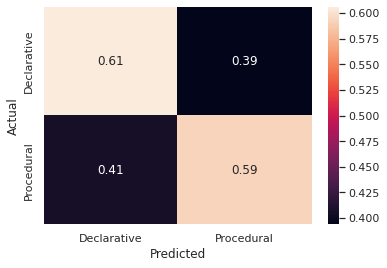

In [138]:
confusion_matrix = pd.crosstab(recovery_df['orig.model'], recovery_df['best.model'], rownames=['Actual'], colnames=['Predicted'], margins=False)
sns.heatmap(confusion_matrix/1990, annot=True, fmt=".2f")
plt.show()


In [139]:
proc = recovery_df[recovery_df['orig.model']=="Procedural"]
decl = recovery_df[recovery_df['orig.model']=="Declarative"]

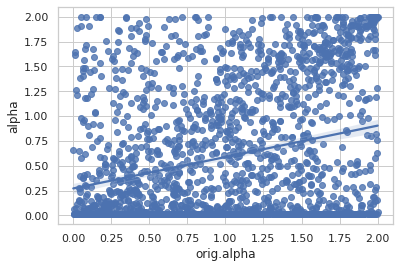

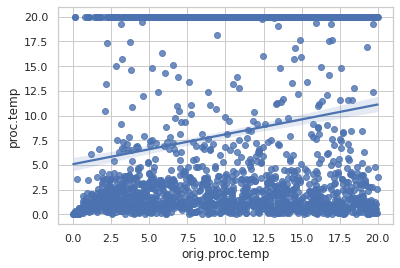

In [140]:
sns.regplot(data=proc, x="orig.alpha", y="alpha")
plt.show()
sns.regplot(data=proc, x="orig.proc.temp", y="proc.temp")
plt.show()

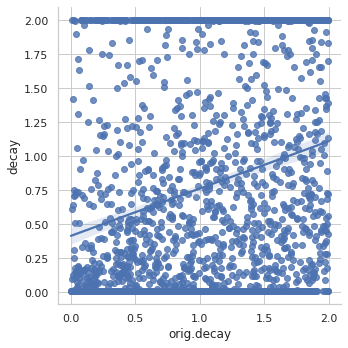

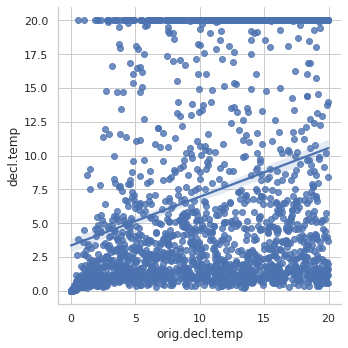

In [141]:
sns.lmplot(data=decl, x="orig.decay", y="decay")
plt.show()
sns.lmplot(data=decl, x="orig.decl.temp", y="decl.temp")
plt.show()

## By subject

In [142]:
recovery_df['recovery.acc'] = np.where(recovery_df['orig.model'] == recovery_df['best.model'], 1, 0)
agg=recovery_df.groupby(['HCPID', 'orig.model']).mean()

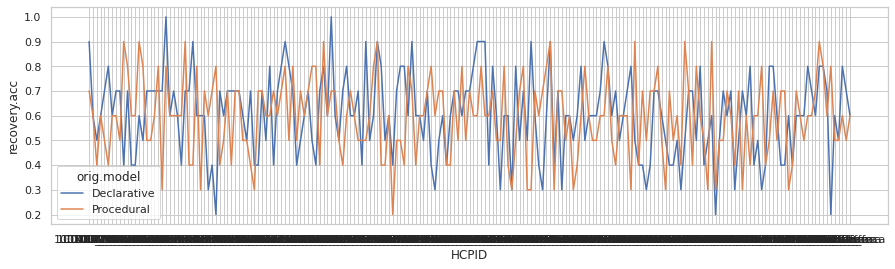

In [143]:
fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(data=agg, ax=ax, x="HCPID", y="recovery.acc", hue="orig.model")
plt.show()

# by parameter

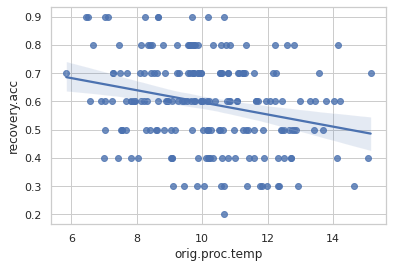

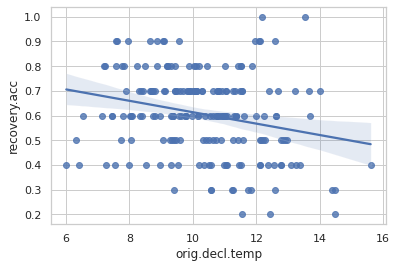

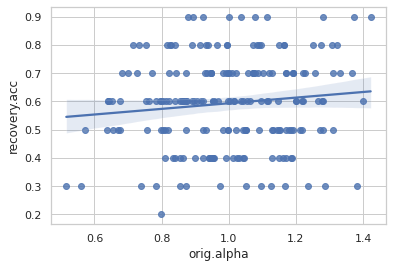

In [155]:
sns.regplot(data=agg, x="orig.proc.temp", y="recovery.acc")
plt.show()
sns.regplot(data=agg, x="orig.decl.temp", y="recovery.acc")
plt.show()
sns.regplot(data=agg, x="orig.decay", y="recovery.acc")
plt.show()